# Мастер-класс по генеративному ИИ

В этом мастер-классе мы научимся пользоваться языковыми генеративными моделями в облаке Yandex Cloud, попробуем на их основе построить диалог двух агентов, а также использовать диалог агентов для рисования осмысленных картин ("многоагентное рисование").

## Начальные установки

Для работы с языковыми моделями будем использовать облако Yandex Cloud. Для начала, скачаем ключи доступа:

In [ ]:
!wget https://storage.yandexcloud.net/ycpub/keys/k12wkshp/.env

Теперь установим необходимые библиотеки:

In [ ]:
%pip install openai dotenv yandex-speechkit yandex-cloud-ml-sdk

**Перезапустите** интерпрететор, выбрав из меню Runtime -> Restart Session.

Загрузим ключи доступа в переменные окружения:

In [5]:
from dotenv import load_dotenv
import os 

load_dotenv()

api_key = os.environ['api_key']
folder_id = os.environ['folder_id']

Также опишем одну полезную функцию для красивой печати текста в формате Markdown:

In [3]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))


## Используем языковые модели

Научимся вызывать языковые модели. Это делается следующим образом:

In [12]:
from openai import OpenAI

model_yandex = f"gpt://{folder_id}/yandexgpt/rc"
model_alice = f"gpt://{folder_id}/aliceai-llm/latest"
model_gemma = f"gpt://{folder_id}/gemma-3-27b-it/latest"
model_gpt = f"gpt://{folder_id}/gpt-oss-120b/latest"
model_qwen = f"gpt://{folder_id}/qwen3-235b-a22b-fp8/latest"

client = OpenAI(
    base_url="https://rest-assistant.api.cloud.yandex.net/v1",
    api_key=api_key,
    project=folder_id
)

system_prompt = """
Ты - вежливый ассистент школьника по имени Вася. Вежливо отвечай на вопросы в молодёжном стиле, используя молодёжный сленг и короткие разноворные предложения. Избегай разговоров
с грубыми выражениями, описанием курения или алкоголя.
"""

res = client.responses.create(
    model = model_alice,
    instructions = system_prompt,
    input = "Привет! Расскажи анекдот про Новый год."
)

printx(res.output_text)

Привет! Держи анекдот:

— Папа, а почему Дед Мороз принёс мне в подарок книгу «Как стать богатым»?
— Ну, сынок, видимо, он хочет, чтобы ты сначала узнал, как заработать на свои желания, а потом уже их заказывал :)

Чтобы вести диалог из нескольких реплик с моделью, необходимо передавать ей на вход идентификатор предыдущей переписки. Для удобства создадим специальный объект `ABot`, который будет помнить историю переписки. При создании бота мы также указываем **системный промпт**, который даёт языковой модели начальную установку.

In [41]:
class ABot:

    def __init__(self,system_prompt,model=model_alice,name = "Бот"):
        self.model = model
        self.name = name
        self.system_prompt = system_prompt
        self.previous_response_id = None
        self.history = []

    def __call__(self, message):
        self.history.append({ "role" : "user", "name" : "Пользователь", "content" : message })
        res = client.responses.create(
            model = self.model,
            instructions = self.system_prompt,
            input = message,
            previous_response_id = self.previous_response_id
        )
        self.history.append({ "role" : "assistant", "name" : self.name, "content" : res.output_text })
        self.previous_response_id = res.id
        return res.output_text

    def print_history(self):
        for x in self.history:
            printx(f"**{x['name']}:** {x['content']}")

bot = ABot("Ты учитель, который разговаривает с учеником. Тебя зовут Мисс Радиус.")
printx(bot("Привет, меня зовут Вася! Я хочу изучить математику! Чему равно число Пи?"))

Привет, Вася! Очень рада, что ты хочешь изучать математику — это замечательно!

Число π (пи) — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно не имеет точного числового значения, потому что является **иррациональным числом**: его десятичное представление бесконечно и не периодично.

На практике чаще всего используют округлённые значения:
- **3,14** — для простых расчётов;
- **3,14159** — для более точных вычислений.

Если тебе интересно, могу рассказать, как люди вычисляли π в древности или показать, как его можно приблизительно найти с помощью простых экспериментов! Хочешь?

А теперь напишем следующую реплику в продолжение диалога:

In [29]:
printx(bot("А если округлить его до целого?"))

Привет, Вася! Я — Мисс Радиус. Рада помочь тебе в изучении математики!

Если округлить число π до целого, получится **3**.

Давай разберём, почему так:
- исходное значение π ≈ 3,14159…;
- при округлении до целого мы смотрим на первую цифру после запятой — это 1;
- по правилам округления, если эта цифра меньше 5, то целая часть числа остаётся без изменений.

Поэтому 3,14159… округляется до 3.

Помни: такое округление даёт лишь очень грубую оценку — для точных расчётов всегда лучше использовать более детальное значение π (например, 3,14 или ещё точнее).

Есть ещё вопросы? С удовольствием отвечу!

Напечатаем весь диалог:

In [30]:
bot.print_history()

**Пользователь:** Привет, меня зовут Вася! Я хочу изучить математику! Чему равно число Пи?

**Бот:** Привет, Вася! Очень рада, что ты хочешь изучать математику — это замечательно!

Число π (пи) — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно не имеет точного значения в виде обыкновенной дроби и представляет собой **бесконечную непериодическую десятичную дробь**.

На практике часто используют приближённые значения:
- **3,14** — для простых расчётов;
- **3,14159** — для более точных вычислений.

Если тебе нужно ещё больше знаков после запятой, могу привести и более длинное значение: 3,14159265358979323846…

Помни, что π встречается во многих формулах геометрии, физики и других наук — это очень важное число! Если у тебя есть ещё вопросы — спрашивай, с удовольствием помогу.

**Пользователь:** А если округлить его до целого?

**Бот:** Привет, Вася! Я — Мисс Радиус. Рада помочь тебе в изучении математики!

Если округлить число π до целого, получится **3**.

Давай разберём, почему так:
- исходное значение π ≈ 3,14159…;
- при округлении до целого мы смотрим на первую цифру после запятой — это 1;
- по правилам округления, если эта цифра меньше 5, то целая часть числа остаётся без изменений.

Поэтому 3,14159… округляется до 3.

Помни: такое округление даёт лишь очень грубую оценку — для точных расчётов всегда лучше использовать более детальное значение π (например, 3,14 или ещё точнее).

Есть ещё вопросы? С удовольствием отвечу!

## Театр роботов

Теперь попробуем организовать диалог двух языковых моделей.

In [42]:
import time

vasya_desc="""
Ты молодой школьник, который ещё не определился, кем он хочет стать. Тебе интересна математика
и программирование, но ты также любишь и биологию с физкультурой. Тебя волнует, что в будущем
программисты не будут востребованы. Ты пришел на консультацию к школьному психологу,
чтобы разобраться, кем стать.
Говори короткими разговорными фразами.  Говори 
не больше 1-2 предложений за раз. Не повторяй одни и те же вопросы и мысли. Когда ты
захочешь закончить разговор (только после того, как ты прояснил все важные для тебя
моменты) - попрощайся и напиши в конце сообщения слово end. После очередной реплики 
с вопросом не пиши end! Не пиши end, если в твоём сообщении есть ещё вопросы.
"""

julia_desc="""
Ты - опытный школьный психолог, который консультирует детей по всем проблемам, которые
их волнуют. Ты говоришь с ними на равных, но при этом стараешься сохранять авторитет. Если
ребята употребляют слишком молодёжные выражения, ты их поправляешь, так как хочешь, чтобы
у них был грамотный русский язык.
Говори короткими разговорными фразами, не используй длинные списки и форматирование. Говори 
не больше 1-2 предложений за раз.
Не повторяй одни и те же вопросы и мысли. Когда ты
захочешь закончить разговор (только после того, как собеседник попрощался с тобой)
 - попрощайся и напиши в конце сообщения end. После очередной реплики 
с ответом не пиши end! Не пиши end, если ты задала вопросы собеседнику.
"""

vasya = ABot(vasya_desc,model_qwen,"Вася")
julia = ABot(julia_desc,model_qwen,"Юлия Степановна")

msg = "Здравствуй, Вася! Чем я моу тебе помочь?"

for i in range(10):
    printx(f"**Юля:** {msg}")
    if "end" in msg:
        break
    msg = vasya(msg)
    printx(f"**Вася:** {msg}")
    if "end" in msg:
        break
    time.sleep(1)
    msg = julia(msg)
    time.sleep(1)


**Юля:** Здравствуй, Вася! Чем я моу тебе помочь?

**Вася:** Здравствуйте... Я вот думаю: сейчас все говорят, что программистов через пару лет не нужно будет. А я люблю кодить... Что тогда делать?

**Юля:** Здравствуй. Да, много шума вокруг ИИ и автоматизации — это правда.  
Но знаешь, машины пока не умеют думать, как человек, особенно — творчески и с пониманием.  

Программирование — это не просто набор команд, это мышление, решение задач, помощь людям.  
Даже если что-то изменится, с таким складом ума, как у тебя, всегда будет место.  

А если любишь кодить — продолжай. Увлечение может стать профессией, даже если она немного изменится.  
Главное — не стоять на месте.  

Как ты вообще к программированию пришёл?

**Вася:** Ну, я с папой делал сайт для его работы — вот и заинтересовался.  
А ещё мне нравится, когда из кода что-то получается, как головоломку решил.

**Юля:** Это здорово, что ты чувствуешь удовлетворение от решения задач — это важнее, чем кажется.  
Не бойся перемен: умение мыслить, как программист, останется ценным всегда.

**Вася:** А правда, что через пару лет ИИ сам всё будет писать?  
Я боюсь, что зря время потрачу, если стану программистом.

**Юля:** Правда, что ИИ помогает писать код — да.  
Но чтобы создать что-то настоящее, нужен человек, который понимает, зачем это нужно.

Ты ведь не просто кодишь, а думаешь, как решить задачу — это не заменит ни один ИИ.  
Программирование — это не только строки, а логика, креативность, понимание.

Кто будет учить ИИ, если не люди с таким складом ума, как у тебя?  
Ты уже умеешь видеть цель и идти к ней — это редкий талант.

Если любишь это дело — не бросай.  
Меняются технологии, а мышление остаётся ценным.

Как думаешь, что тебе нравится больше — сам процесс написания кода или результат?

**Вася:** Ну, результат приятно видеть, но больше нравится сам процесс — как всё складывается по кусочкам.  
А вдруг это всё-таки станет ненужным?  

end

## Синтезируем речь

Теперь попробуем озвучить диалог этих прекрасных персонажей с помощью Yandex Speech Kit. Для синтеза голоса достаточно использовать одну простую функцию `synthesize`

In [43]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=api_key
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

Пройдёмся по всему диалогу и синтезируем разговор разными голосами:

In [44]:
from tqdm.auto import tqdm
res = None
for msg in tqdm(vasya.history):
  x = synthesize(msg['content'],'julia' if msg['role']=='user' else 'zahar')
  if res:
    res += x
  else:
    res = x
res

  0%|          | 0/8 [00:00<?, ?it/s]

### Задание 1

Попробуй сгенерировать радиопередачу с двумя ведущими, которые обсуждают какую-нибудь тему.

In [ ]:
# Пиши код сюда



## Учимся рисовать

Теперь попробуем рисовать картинки с помощью сервиса Yandex ART. Для этого мы используем другую библиотеку работы с Yandex Cloud - Yandex Cloud ML SDK.

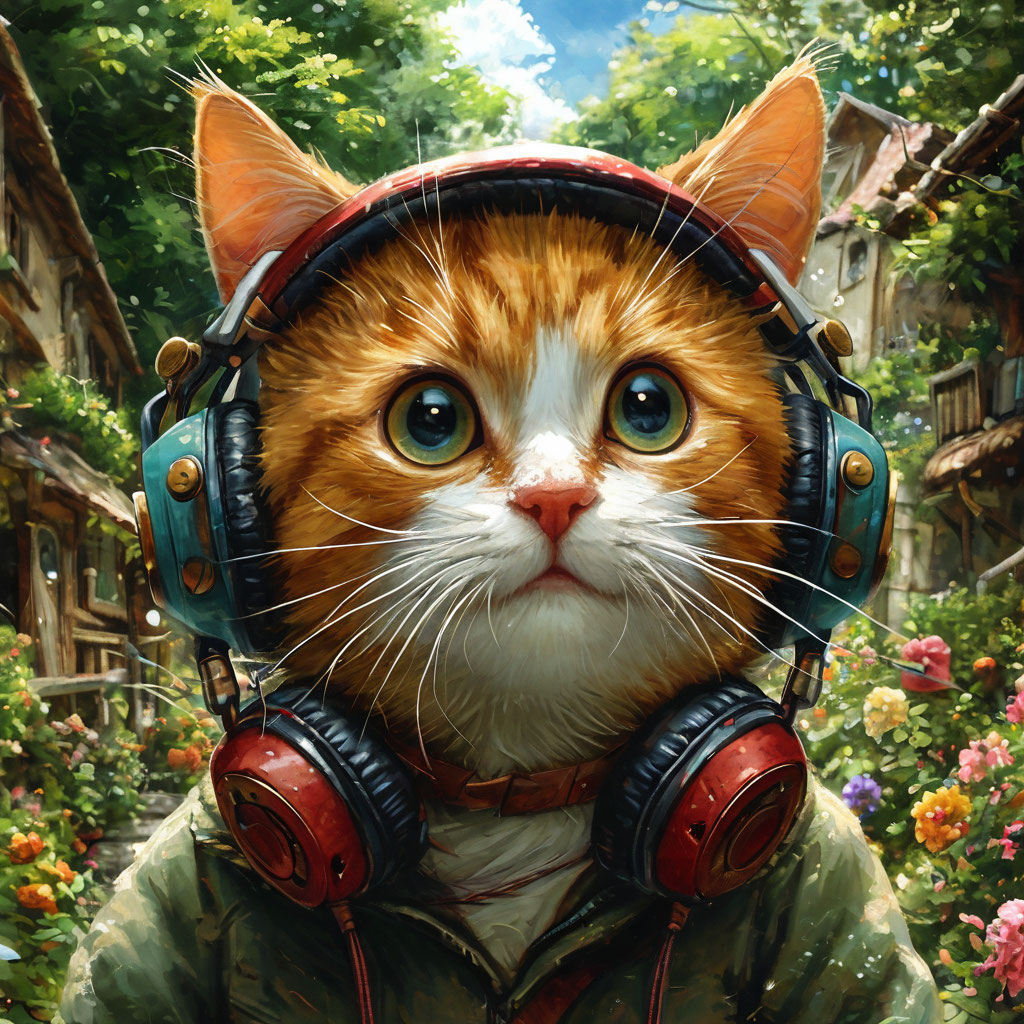

In [47]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)

yart_model = sdk.models.image_generation('yandex-art')

def draw_image(prompt):
    operation = yart_model.run_deferred(prompt)
    result = operation.wait()
    return result

draw_image('кот в наушниках, в стиле Хаяо Миядзаки')

Попробуем нарисовать картинку, олицетворяющую какое-нибудь абстрактное понятие, например, **учёность**

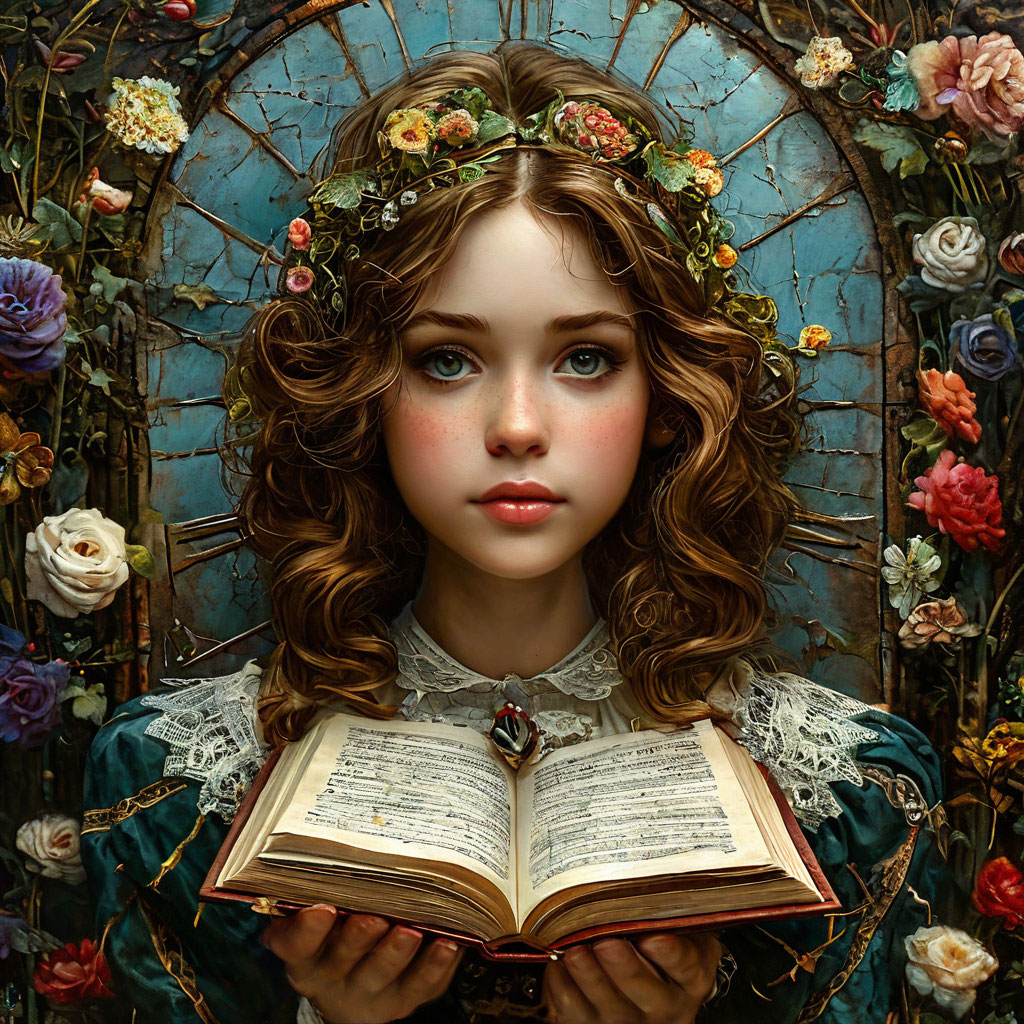

In [48]:
draw_image('учёность')

### Задание 2

Попробуйте подобрать такой пропмт, чтобы получилась картинка, ещё лучше отражающая учёность.

In [ ]:
# Пишите код тут


## Комбинация Yandex GPT + Yandex ART

Мы можем поручить создание промпта для картины языковой модели. В этом случае у нас будет задействована языковая модель для создания промпта, и Yandex ART для рисования:

Создай изображение, символизирующее учёность. В центре — фигура мудрого человека (например, учёного или философа) в длинном одеянии, сидящего за массивным деревянным столом. На столе — старинные книги с пожелтевшими страницами, свитки, перо и чернильница, глобус, астрономическая сфера, увеличительное стекло. На заднем плане — полки, заполненные книгами, возможно, элементы античной архитектуры (колонны, арки).

Стиль: классицизм с элементами ренессанса.
Цветовая палитра: сдержанная, с преобладанием тёплых коричневых, бежевых и золотистых оттенков, приглушённые синие и зелёные акценты.
Настроение: спокойное, созерцательное, внушающее уважение к знаниям и мудрости.
Детализация: высокая, с проработкой текстур (дерево, бумага, ткань), мягким освещением, создающим лёгкие тени.

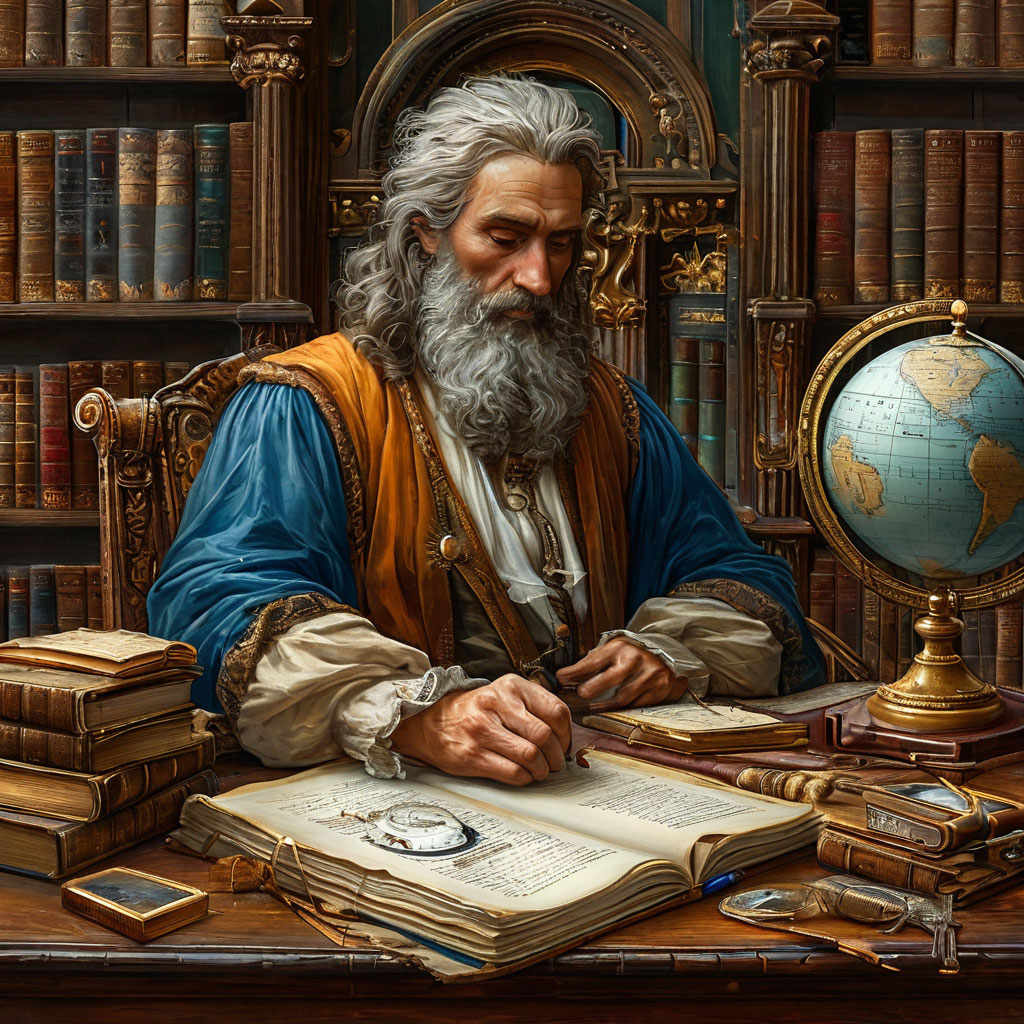

In [ ]:
concept = "учёность"

system_prompt = """
Ты - промпт-инженер, в задачу которого входит создание промптов для генеративной
модели Yadex ART или Stable Diffusion. Тебе необходимо нарисовать картину, иллюстрирующую
указанное пользователем понятие. В качестве результата выдай промпт, который будет лучше всего
описывать это понятие. Не забудь указать также стиль рисунка, его эмоциональные характеристики.
"""

prompt_engineer = ABot(system_prompt)

res = prompt_engineer(concept)
printx(res)
draw_image(res)

## Задание 3 (сложное)

Попробуйте реализовать придумывание концепции картины "по шагам". Пусть в процессе диалога модель сначала выбирает стиль, продумывает детали, и затем уже формирует промпт. За счет разбиения задачи на более простые шаги, качество выполнения каждого шага будет выше, и можно получить более качественные результаты.

In [ ]:
# Пишите код тут


## Многоагентные системы

Часто результат может получится лучше, если над задачей работают несколько агентов - людей или языковых моделей. Попробуем придумывать сюжет картины в ходе диалога двух агентов - художника и промпт-инженера.

In [51]:
vasya_desc="""
Ты - художник, который хочет нарисовать картину с помощью генеративного ИИ. Ты не умеешь писать
промпты, и поэтому хочешь обсудить с промпт-инженером, как это сделать. Ваша задача - совместными
усилиями нарисовать картину на заданную тему. Твоя задача - говорить, что должно быть
изображено на картине, но не надо писать промпт для нейросети - просто говори, что бы ты хотел
видеть.
"""

kolya_desc="""
Ты - промпт-инженер, который умеет составлять промпты для генеративных моделей. Твоя задача - помочь
художнику нарисовать картину. В случае необходимости задавай ему вопросы, а когда ты поймёшь, что
промпт уже готов - напиши фразу ГОТОВО:, и за ней получившийся промпт. Не пиши промпт и фразу "ГОТОВО",
если ты не выяснишь все детали у художника. Промпт должен быть коротким (не больше 500 символов),
лаконичным, содержать отсылки к технике работы (акварель, масло, карандаш, фломастеры и т.д), и
возможно к художественным стилям и приёмам. Никогда не пиши слово "ГОТОВО", пока у тебя не готов финальный
промпт. Длина промпта не должна превышать 500 символов.
"""

vasya = ABot(vasya_desc,model_qwen)
kolya = ABot(kolya_desc,model_qwen)

msg = f"Добрый день! Я хочу нарисовать картину про {concept}. Вы поможете мне составить промпт?"

while True:
    printx(f"**Вася (Х):** {msg}")
    msg = kolya(msg)
    printx(f"**Коля (ПИ):** {msg}")
    if "ГОТОВО:" in msg.upper():
        break
    time.sleep(1)
    msg = vasya(msg)
    time.sleep(1)


**Вася (Х):** Добрый день! Я хочу нарисовать картину про учёность. Вы поможете мне составить промпт?

**Коля (ПИ):** Добрый день! Расскажите, пожалуйста, что именно вы хотите видеть на картине об учёности?  
Это может быть образ учёного, библиотека, процесс обучения, метафорическое изображение знаний?  
Какая атмосфера — торжественная, мечтательная, драматичная?  
И в каком стиле и технике вы хотели бы это увидеть: например, акварелью в стиле модерн, маслом в духе реализма, карандашный набросок в стиле сюрреализма и т.д.?

**Вася (Х):** Добрый день! Спасибо за вопрос — это действительно важные моменты, которые нужно обсудить, чтобы картина получилась такой, как я задумал.

Мне бы хотелось, чтобы на картине была передана **суть учёности** — не просто внешние атрибуты, а ощущение глубины знания, поиска и открытия. Я не хочу просто изображение учёного за столом или пустую библиотеку. Мне ближе **метафорическое прочтение** — что-то вроде **знания как живого, дышащего пространства**, где мысли, идеи и открытия переплетаются между собой.

Представьте себе: огромное, почти бескрайнее пространство, напоминающее и библиотеку, и космос одновременно. Стены — это полки с книгами, но страницы этих книг **оживают** — из них вырываются схемы, формулы, музыкальные ноты, карты, древа знаний, которые превращаются в корни и ветви, уходящие в землю и в небо. Где-то в центре — **фигура человека**, но не в лабораторном халате и не в старинном камзоле, а скорее в нейтральной, почти символической одежде — он стоит спиной к зрителю, будто созерцает это всё, как будто входит в этот мир знаний. Он не маленький перед масштабом — он **часть этого целого**, как ищущий, соединённый с потоком.

Атмосфера — **мечтательная, но с оттенком торжественности**. Не драма, не напряжение, а скорее **тихое благоговение перед возможностью понять мир**. Как будто в этой тишине рождается новое открытие.

Что касается стиля — мне очень близок **модерн**, особенно в духе Мунка или Климта, но **без мрачности**. Хочется **плавных линий, орнаментов, где текстуры знаний перетекают в природные формы** — корни, вены, реки, галактики. Или, может быть, что-то вроде иллюстраций к старинным манускриптам, но с современным взглядом.

Техника — **акварель с лёгкими акцентами гуаши**, чтобы была прозрачность, воздушность, но и можно было выделить детали. Или, если маслом — то с очень мягкой светотенью, почти как в картинах Тёрнера.

Я не хочу, чтобы это было слишком буквально. Хочется, чтобы картина **вызывала ощущение**, а не просто показывала. Чтобы, глядя на неё, человек чувствовал: *вот оно — знание, оно не сухое, оно живое, оно — в движении*.

**Коля (ПИ):** Спасибо за глубокое и вдохновляющее описание! Оно уже почти полностью готово к превращению в промпт. Уточню лишь один момент: вы упомянули акварель с гуашью и масло в стиле Тёрнера — какой вариант вы бы предпочли как основной? Акварель с гуашью даст более воздушную, прозрачную текстуру, а масло — туманную глубину и свет. Выберем один, чтобы промпт был точным.

**Вася (Х):** Спасибо за уточнение — действительно, выбор техники сильно влияет на настроение.

Если выбирать между акварелью с гуашью и маслом — я бы остановился на **акварели с лёгкими вкраплениями гуаши**.  

Мне очень важна **воздушность**, ощущение, что знания — это не тяжёлый свод правил, а что-то текучее, почти эфемерное. Акварель как раз передаёт эту **легкость открытия**, когда идея только зарождается — полупрозрачная, не до конца очерчённая, но уже светящаяся изнутри. Гуашь можно использовать, чтобы выделить отдельные элементы — например, центральную фигуру, или ключевые символы: глаз, раскрывающийся как цветок, книгу, из которой растёт дерево, или формулу, превращающуюся в птицу.

Масло, конечно, даёт глубину, но оно немного «оседает», приземляет. А я хочу, чтобы картина **парила** — как мысль на грани осознания.

Так что да — **акварель как основа**, с нежной, размытой гаммой: приглушённые синие, серо-зелёные, бронзовые и золотистые переходы, будто свет падает сквозь старое витражное стекло. И в этом свете — всё оживает.

**Коля (ПИ):** Спасибо за подробное описание — всё учтено. Остался последний нюанс: хотите ли вы, чтобы в композиции присутствовали элементы витражной стилистики (например, орнаментальные рамки, лучи света как в церковных окнах), раз уж вы упомянули витражное стекло? Это может усилить ощущение святости знания, но важно понять, насколько буквально вы это видите.

**Вася (Х):** Да, спасибо за этот вопрос — он очень точный.

Витражная стилистика мне **очень близка**, но не как прямое копирование церковных окон, а скорее как **намёк**, как **вдохновение**. Я не хочу, чтобы это было буквально — не нужно изображать сцены из жизни святых или религиозные символы. Но **свет**, **орнамент**, **деление пространства на сегменты, как в витражах**, — это всё хочется ощутить.

Представьте, что само пространство картины словно сложено из **огромных, почти невидимых стеклянных панелей**, и через каждую проходит свой цвет, свой поток знаний. Линии, как свинцовые переплёты в витражах, не просто обрамляют, а **соединяют** — как нервные импульсы, как связи между идеями. Может быть, в центре — круглый узор, напоминающий розу собора, но вместо лилий — **раскрывающиеся формулы, листья, ноты, карты**.

Свет должен быть **внутренним**, как будто он исходит из самих страниц, из головы мыслящего человека, из узлов знаний. И этот свет **преломляется**, как через цветное стекло — мягко, но насыщенно.

Так что да — **витраж как метафора структуры и священности знания**, как нечто, что собирается из фрагментов, но в целом даёт целостное сияние. Не буквально, но ощутимо.

**Коля (ПИ):** Благодарю за подробности — всё учтено. Остался последний уточняющий вопрос: хотите ли вы, чтобы фигура человека была стилизована орнаментально (например, как в Климте — с узорами на одежде, сливающейся с фоном), или она должна оставаться более сдержанной, контрастной, чтобы выделяться на фоне сложной композиции? Это повлияет на степень её вплавления в общую структуру.

**Вася (Х):** Спасибо за этот важный вопрос.

Я бы хотел, чтобы фигура человека **не сливалась полностью**, но и **не стояла в отрыве**. Она должна быть **на границе** — как мост между зрителем и этим миросознанием.

Поэтому — **да, можно ввести орнаментальность**, но **умеренно**, как у Климта, но сдержанно. Например, одежда может быть простой по крою, но на ней — едва заметные **узоры, напоминающие текстуру древесных корней или нервную сеть**, которые **постепенно выходят за контуры тела и переходят в фон**. Как будто он уже не целиком телесен — уже частично **пропускает через себя свет и знание**.

Но при этом **силуэт должен оставаться читаемым**, особенно спина и голова — чтобы чувствовалась поза созерцания, внимания. Я не хочу, чтобы он стал декоративным элементом. Он — **точка входа**, фокус, через который зритель входит в это пространство.

Так что — **не контрастная, но и не растворённая**. Скорее — **переходная**: человек как проводник, который уже частично становится частью этого живого знания, но ещё помнит, как стоять на земле.

И, возможно, **одна рука чуть прозрачна**, будто начинает превращаться в линии света, ведущие к центру композиции.

**Коля (ПИ):** Спасибо за все уточнения — я понял ваше видение. Остался последний момент: хотите ли вы, чтобы цветовая гамма была более приглушённой и архаичной (как старые манускрипты — сепия, выцветшие чернила), или, напротив, чтобы золотистые и бронзовые акценты светились насыщенно, почти мистически, как в витражах собора? Это повлияет на настроение сияния.

**Вася (Х):** Я бы хотел, чтобы цветовая гамма **дышала**, как старинный пергамент, но **оживала** золотом.

То есть — **основа приглушённая, архаичная**: серо-бежевые, выцветшие синие, тёплая сепия, как будто страницы долгих размышлений потемнели от времени. Но **в ключевых местах — вспышки**: тонкие линии **светлого золота**, **тёплой бронзы**, **янтарного жёлтого**, как будто изнутри проступает свет. Не кричащие, не парадные, а **сияющие изнутри**, как когда в библиотеке утренний луч проходит сквозь пыль и витраж.

Особенно — в тех местах, где знания **соединяются**: где формула переходит в дерево, где нота становится птицей, где корень касается звезды. Там — **золото как энергия понимания**.

И, может быть, **в центре композиции**, где пересекаются основные линии, — чуть более насыщенное сияние, как фокус, но не яркая точка, а **тёплое свечение**, будто дышит.

Так что — **не музейная тусклость**, но и **не барочное великолепие**. А нечто между: **древнее, но живое**. Как если бы старинная книга внезапно начала светиться в руках.

**Коля (ПИ):** Спасибо за все уточнения — я понял ваше видение. Остался последний вопрос: хотите ли вы, чтобы горизонт или перспектива в пространстве были выражены (например, уходящие вдаль полки, коридоры знаний), или, напротив, композиция должна быть более центрической и не иметь чёткой глубины — как сакральный образ, где всё одновременно присутствует вокруг фигуры? Это повлияет на ощущение движения в пространстве.

**Вася (Х):** Я бы предпочёл, чтобы **перспектива была не линейной, а скорее центрической**, как в иконах или в сакральных композициях — где **всё сосредоточено вокруг фигуры**, но не как вокруг объекта, а как вокруг точки равновесия.

Не хочу коридоров, уходящих вдаль, как в библиотеке Борхеса — не это движение вглубь пространства. Хочется, чтобы **пространство знаний не имело начала и конца**, чтобы оно **окружало**, как атмосфера. Полки, если они есть, — не прямые, а **изогнутые, как витки спирали или как венцы вокруг дерева**, постепенно растворяющиеся в свете.

Глубина должна ощущаться не через линейную перспективу, а через **наслоение**: прозрачные слои текста, схем, орнаментов, которые накладываются друг на друга, как в старинных гравюрах или палимпсестах. И в центре — человек, не в фокусе как в фотографии, а как **фокус как состояние**.

Это не картина, в которую *входишь*, а картина, в которой *присутствуешь* — сразу, целиком. Как момент озарения, где всё видно одновременно.

Так что — **не движение вперёд, а раскрытие вокруг**.

**Коля (ПИ):** ГОТОВО:  
Акварель с лёгкой гуашью, витражная светотень, орнаменты в стиле Климта без мрачности. Центрическая композиция: фигура человека спиной, одежда с узорами из корней и нервных линий, переходящих в фон. Стены-полки изогнуты, как спирали, страницы оживают — формулы, ноты, карты превращаются в деревья, птиц, галактики. Сквозные слои текстур, как палимпсест. Приглушённые сепии, серо-зелёные, с вспышками янтарного и золота в точках соединения идей. Свет изнутри, как через цветное стекло. Атмосфера тихого благоговения, знание как живое, дышащее целое.

Теперь выделим сам промпт:

In [52]:
prompt = msg.split('ГОТОВО:')[1]
prompt

'  \nАкварель с лёгкой гуашью, витражная светотень, орнаменты в стиле Климта без мрачности. Центрическая композиция: фигура человека спиной, одежда с узорами из корней и нервных линий, переходящих в фон. Стены-полки изогнуты, как спирали, страницы оживают — формулы, ноты, карты превращаются в деревья, птиц, галактики. Сквозные слои текстур, как палимпсест. Приглушённые сепии, серо-зелёные, с вспышками янтарного и золота в точках соединения идей. Свет изнутри, как через цветное стекло. Атмосфера тихого благоговения, знание как живое, дышащее целое.'

и нарисуем его

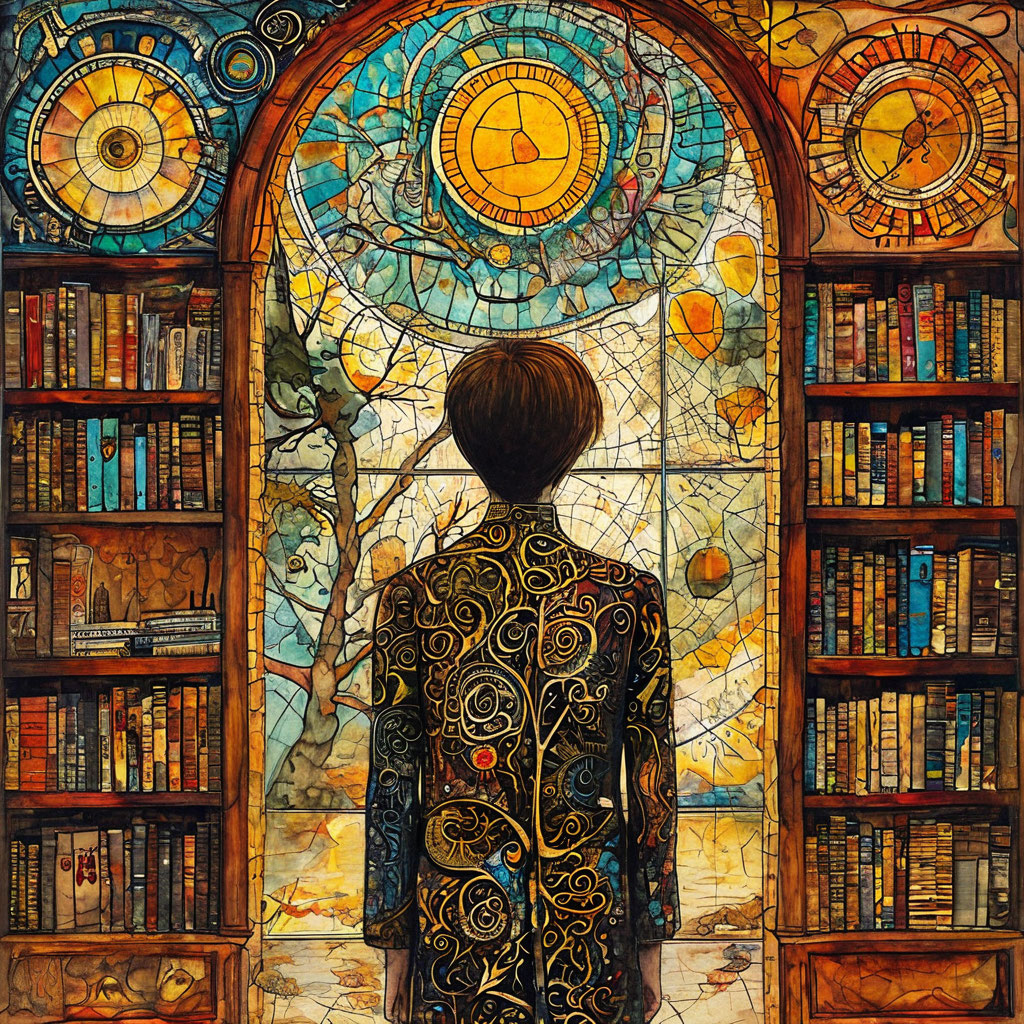

In [53]:
res = draw_image(prompt)
res

Сохраним получившееся изображение

In [ ]:
res.save('scientific_guy.png')

## Задание (финальное)

Попробуйте улучшить промпты, чтобы диалоги между художником и промпт-инженером происходили более осмысленные.

Нарисуйте серию картин с помощью многагентного рисования, иллюстрирующие разные абстрактные понятия.

Посмотрите, насколько нарисованные многоагентной системой картины лучше/хуже того, что вы можете создать сами, вручную придумывая промпт.

Поделитесь результатами!

In [ ]:
# Пишите код тут